In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Load the splits
def load_dakshina_splits(lang_code='hi', base_dir='dakshina_dataset_v1.0'):
    lex_dir = f"{base_dir}/{lang_code}/lexicons/"
    train_path = lex_dir + f"{lang_code}.translit.sampled.train.tsv"
    dev_path   = lex_dir + f"{lang_code}.translit.sampled.dev.tsv"
    test_path  = lex_dir + f"{lang_code}.translit.sampled.test.tsv"
    train_df = pd.read_csv(train_path, sep='\t', header=None, names=['native', 'latin', 'count'], na_filter = False)
    dev_df   = pd.read_csv(dev_path,
                           sep='\t', header=None, names=['native', 'latin', 'count'], na_filter = False)
    test_df  = pd.read_csv(test_path,  sep='\t', header=None, names=['native', 'latin', 'count'], na_filter = False)
    train_df.drop(["count"], axis = 1,inplace = True)
    dev_df.drop(["count"], axis = 1,inplace = True)
    test_df.drop(["count"], axis = 1,inplace = True)

    return train_df, dev_df, test_df

# 2. Preprocessing: add <start> and <end> tokens, tokenize as characters
def preprocess_df(df):
    def process(text):
        return ' '.join(['<start>'] + list(str(text).strip()) + ['<end>'])
    df['native_proc'] = df['native'].apply(process)
    df['latin_proc'] = df['latin'].apply(process)
    return df

# 3. Build vocabulary from training data only
def build_vocab(texts):
    special_tokens = ['<pad>', '<unk>', '<start>', '<end>']
    chars = set()
    for text in texts:
        chars.update(text.split())
    chars = [c for c in sorted(chars) if c not in special_tokens]
    vocab = special_tokens + chars
    char2idx = {c: i for i, c in enumerate(vocab)}
    idx2char = {i: c for i, c in enumerate(vocab)}
    return char2idx, idx2char

# 4. Convert text to padded sequences of indices
def texts_to_sequences(texts, vocab, max_len=None):
    seqs = []
    for text in texts:
        seq = [vocab.get(c, vocab['<unk>']) for c in text.split()]
        seqs.append(seq)
    if not max_len:
        max_len = max(len(seq) for seq in seqs)
    padded_seqs = [seq + [vocab['<pad>']] * (max_len - len(seq)) for seq in seqs]
    # print(padded_seqs , max_len)
    return np.array(padded_seqs), max_len

# 5. PyTorch Dataset
class TransliterationDataset(Dataset):
    def __init__(self, src_seqs, trg_seqs):
        self.src = torch.LongTensor(src_seqs)
        self.trg = torch.LongTensor(trg_seqs)
    def __len__(self):
        return len(self.src)
    def __getitem__(self, idx):
        return {
            'source': self.src[idx],
            'target': self.trg[idx],
            'target_input': self.trg[idx][:-1],  # Exclude <end>
            'target_output': self.trg[idx][1:]   # Exclude <start>
        }

# 6. Main function to prepare everything
def prepare_dakshina_data(base_dir,lang_code='hi', batch_size=64):
    # Load splits
    train_df, dev_df, test_df = load_dakshina_splits(lang_code,base_dir)
    train_df = preprocess_df(train_df)
    dev_df = preprocess_df(dev_df)
    test_df = preprocess_df(test_df)

    # Build vocabs from training only
    src_vocab, src_idx2char = build_vocab(train_df['latin_proc'])
    trg_vocab, trg_idx2char = build_vocab(train_df['native_proc'])

    # Find max lengths across all splits for consistent padding
    src_max_len = max(
        train_df['latin_proc'].apply(lambda x: len(x.split())).max(),
        dev_df['latin_proc'].apply(lambda x: len(x.split())).max(),
        test_df['latin_proc'].apply(lambda x: len(x.split())).max()
    )
    trg_max_len = max(
        train_df['native_proc'].apply(lambda x: len(x.split())).max(),
        dev_df['native_proc'].apply(lambda x: len(x.split())).max(),
        test_df['native_proc'].apply(lambda x: len(x.split())).max()
    )

    # Convert to sequences
    train_src, _ = texts_to_sequences(train_df['latin_proc'], src_vocab, src_max_len)
    train_trg, _ = texts_to_sequences(train_df['native_proc'], trg_vocab, trg_max_len)
    dev_src, _ = texts_to_sequences(dev_df['latin_proc'], src_vocab, src_max_len)
    dev_trg, _ = texts_to_sequences(dev_df['native_proc'], trg_vocab, trg_max_len)
    test_src, _ = texts_to_sequences(test_df['latin_proc'], src_vocab, src_max_len)
    test_trg, _ = texts_to_sequences(test_df['native_proc'], trg_vocab, trg_max_len)

    # Datasets and loaders
    train_dataset = TransliterationDataset(train_src, train_trg)
    dev_dataset = TransliterationDataset(dev_src, dev_trg)
    test_dataset = TransliterationDataset(test_src, test_trg)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size )

    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'src_vocab': src_vocab,
        'trg_vocab': trg_vocab,
        'src_idx2char': src_idx2char,
        'trg_idx2char': trg_idx2char,
        'src_max_len': src_max_len,
        'trg_max_len': trg_max_len,
    }

# Example usage
PATH = "/kaggle/input/dakshina-attn/dakshina_dataset_v1.0"
data = prepare_dakshina_data(lang_code='hi', batch_size=64,base_dir = PATH)
print(f"Source vocab size: {len(data['src_vocab'])}")
print(f"Target vocab size: {len(data['trg_vocab'])}")
print(f"Train batches: {len(data['train_loader'])}")
print(f"Dev batches: {len(data['dev_loader'])}")
print(f"Test batches: {len(data['test_loader'])}")

# Check a batch
batch = next(iter(data['train_loader']))
print("Source batch shape:", batch['source'].shape)
print("Target input batch shape:", batch['target_input'].shape)
print("Target output batch shape:", batch['target_output'].shape)



Source vocab size: 30
Target vocab size: 67
Train batches: 691
Dev batches: 69
Test batches: 71
Source batch shape: torch.Size([64, 22])
Target input batch shape: torch.Size([64, 20])
Target output batch shape: torch.Size([64, 20])


In [5]:

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.energy = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, hidden_size] (decoder state)
        # encoder_outputs: [batch, seq_len, hidden_size]
        
        seq_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # [batch, seq_len, hidden]
        
        energy = self.energy(torch.cat((hidden, encoder_outputs), dim=2))  # [batch, seq_len, 1]
        attention = torch.softmax(energy.squeeze(2), dim=1)  # [batch, seq_len]
        
        context = torch.bmm(attention.unsqueeze(1), encoder_outputs)  # [batch, 1, hidden]
        return context.squeeze(1), attention

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, 
                 embed_dim=64, hidden_size=512,
                 enc_layers=1, dec_layers=2,
                 cell_type='gru', dropout=0.3,
                 attention=True):
        super().__init__()
        
        self.cell_type = cell_type.lower()
        self.attention = attention
        self.hidden_size = hidden_size
        
        # Embedding layers
        self.src_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.trg_embed = nn.Embedding(trg_vocab_size, embed_dim)
        
        # RNN cell selection
        rnn_dict = {
            'rnn': nn.RNN,
            'lstm': nn.LSTM,
            'gru': nn.GRU
        }
        rnn_class = rnn_dict[self.cell_type]
        
        # Encoder
        self.encoder = rnn_class(
            embed_dim, hidden_size, enc_layers,
            dropout=dropout if enc_layers > 1 else 0,
            batch_first=True
        )
        
        # Decoder with attention
        decoder_input_size = embed_dim + (hidden_size if attention else 0)
        self.decoder = rnn_class(
            decoder_input_size, hidden_size, dec_layers,
            dropout=dropout if dec_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention module
        self.attention_layer = Attention(hidden_size) if attention else None
        
        # Final projection
        self.fc = nn.Linear(hidden_size, trg_vocab_size)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        
        # Encoder forward
        src_embedded = self.src_embed(src)
        encoder_outputs, hidden = self._run_encoder(src_embedded)
        
        # Adapt hidden states for decoder
        hidden = self._adapt_hidden(hidden, self.decoder.num_layers)
        
        # Decoder initialization
        inputs = trg[:, 0]
        outputs = torch.zeros(batch_size, trg_len, self.fc.out_features).to(src.device)
        
        for t in range(1, trg_len):
            # Attention context
            if self.attention:
                context, _ = self._get_context(hidden, encoder_outputs)
                embedded = torch.cat([self.trg_embed(inputs), context], dim=1)
            else:
                embedded = self.trg_embed(inputs)
            
            embedded = embedded.unsqueeze(1)  # Add sequence dimension
            
            # RNN step
            output, hidden = self._decoder_step(embedded, hidden)
            
            # Store predictions
            outputs[:, t] = output
            
            # Teacher forcing
            use_teacher = torch.rand(1).item() < teacher_forcing_ratio
            inputs = trg[:, t] if use_teacher else output.argmax(1)
            
        return outputs

    def _run_encoder(self, src_embedded):
        if self.cell_type == 'lstm':
            encoder_outputs, (hidden, cell) = self.encoder(src_embedded)
            return encoder_outputs, (hidden, cell)
        else:
            encoder_outputs, hidden = self.encoder(src_embedded)
            return encoder_outputs, hidden

    def _decoder_step(self, embedded, hidden):
        if self.cell_type == 'lstm':
            hidden, cell = hidden
            output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            return self.fc(output.squeeze(1)), (hidden, cell)
        else:
            output, hidden = self.decoder(embedded, hidden)
            return self.fc(output.squeeze(1)), hidden

    def _adapt_hidden(self, hidden, target_layers):
        """Handle variable encoder/decoder layers"""
        if isinstance(hidden, tuple):  # LSTM
            h, c = hidden
            h = self._adjust_layers(h, target_layers)
            c = self._adjust_layers(c, target_layers)
            return (h, c)
        else:  # RNN/GRU
            return self._adjust_layers(hidden, target_layers)

    def _adjust_layers(self, state, target_layers):
        """Replicate or slice hidden states to match target layers"""
        current_layers = state.size(0)
        if current_layers < target_layers:
            return torch.cat([state] + [state[-1:]]*(target_layers - current_layers))
        return state[-target_layers:]

    def _get_context(self, hidden, encoder_outputs):
        """Compute attention context vector"""
        if self.cell_type == 'lstm':
            hidden = hidden[0]  # Use hidden state, not cell state
        return self.attention_layer(hidden[-1], encoder_outputs)

In [7]:
def train(config=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # with wandb.init(config=config):
    # config = wandb.config
    pad_idx = data['trg_vocab']['<pad>']
    
    # Model initialization
    model = Seq2Seq(
        src_vocab_size=len(data['src_vocab']),
        trg_vocab_size=len(data['trg_vocab']),
        # embed_dim=config.embed_dim,
        # hidden_size=config.hidden_size,
        # enc_layers=config.enc_layers,
        # dec_layers=config.dec_layers,
        # cell_type=config.cell_type,
        # dropout=config.dropout
    ).to(device)
    
    # Training setup
    # optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    best_val_loss = float('inf')
    
    for epoch in range(10):
        # Training
        model.train()
        train_loss = 0
        for batch in tqdm(data['train_loader'], desc=f"Epoch {epoch+1}"):
            src = batch['source'].to(device)
            trg = batch['target'].to(device)
            
            optimizer.zero_grad()
            output = model(src, trg, teacher_forcing_ratio=0.5)
            
            # Reshape for loss calculation
            output = output[:, 1:].reshape(-1, output.size(-1))
            targets = batch['target_output'].to(device).reshape(-1)
            
            loss = criterion(output, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in data['dev_loader']:
                src = batch['source'].to(device)
                trg = batch['target'].to(device)
                
                output = model(src, trg, teacher_forcing_ratio=0)
                output = output[:, 1:].reshape(-1, output.size(-1))
                targets = batch['target_output'].to(device).reshape(-1)
                
                loss = criterion(output, targets)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                mask = targets != pad_idx
                correct += ((predicted == targets) * mask).sum().item()
                total += mask.sum().item()
        
        avg_train_loss = train_loss / len(data['train_loader'])
        avg_val_loss = val_loss / len(data['dev_loader'])
        val_acc = correct / total
        
        # wandb.log({
        #     "epoch": epoch,
        #     "train_loss": avg_train_loss,
        #     "val_loss": avg_val_loss,
        #     "val_acc": val_acc
        # })
        print( "epoch:", epoch,
            "train_loss:", avg_train_loss,
            "val_loss:", avg_val_loss,
            "val_acc:", val_acc)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")


In [11]:
train()

Epoch 1: 100%|██████████| 691/691 [00:34<00:00, 19.86it/s]


epoch: 0 train_loss: 1.7170256698873385 val_loss: 1.1631601323252139 val_acc: 0.6622245678849452


Epoch 2: 100%|██████████| 691/691 [00:34<00:00, 19.80it/s]


epoch: 1 train_loss: 0.7377982871491036 val_loss: 1.0207856003788933 val_acc: 0.7043805251352421


Epoch 3: 100%|██████████| 691/691 [00:35<00:00, 19.66it/s]


epoch: 2 train_loss: 0.6008407523162803 val_loss: 0.9887342517790587 val_acc: 0.7205106214540177


Epoch 4: 100%|██████████| 691/691 [00:35<00:00, 19.68it/s]


epoch: 3 train_loss: 0.515764123624037 val_loss: 0.9397536352060843 val_acc: 0.738388969521045


Epoch 5: 100%|██████████| 691/691 [00:35<00:00, 19.67it/s]


epoch: 4 train_loss: 0.44705534035234823 val_loss: 0.9623684714669767 val_acc: 0.7425122047763557


Epoch 6: 100%|██████████| 691/691 [00:35<00:00, 19.46it/s]


epoch: 5 train_loss: 0.4006581299772483 val_loss: 0.9692226423733477 val_acc: 0.7468993270880063


Epoch 7: 100%|██████████| 691/691 [00:35<00:00, 19.58it/s]


epoch: 6 train_loss: 0.3584940047495272 val_loss: 0.9431126195451488 val_acc: 0.7488784800105555


Epoch 8: 100%|██████████| 691/691 [00:35<00:00, 19.50it/s]


epoch: 7 train_loss: 0.32451788220667804 val_loss: 0.9659254740977633 val_acc: 0.7561683599419449


Epoch 9: 100%|██████████| 691/691 [00:35<00:00, 19.49it/s]


epoch: 8 train_loss: 0.29767385133786073 val_loss: 0.9657042557778566 val_acc: 0.7525728987993139


Epoch 10: 100%|██████████| 691/691 [00:35<00:00, 19.34it/s]


epoch: 9 train_loss: 0.27263494720076 val_loss: 0.9991084708683733 val_acc: 0.7539583058450983


In [8]:
def test_model_and_save_predictions(model, test_loader, 
                                  src_vocab, src_idx2char,
                                  trg_vocab, trg_idx2char, 
                                  filename='vanilla_prediction.tsv'):
    model.eval()
    correct = 0
    total = 0
    pad_idx = trg_vocab['<pad>']
    device = next(model.parameters()).device
    
    inputs_list = []
    predictions_list = []
    targets_list = []

    with torch.no_grad():
        for batch in test_loader:
            src = batch['source'].to(device)
            trg = batch['target'].to(device)
            
            # Greedy decoding
            outputs = model(src, trg, teacher_forcing_ratio=0)
            outputs_reshaped = outputs[:, 1:].reshape(-1, outputs.size(-1))
            targets = batch['target_output'].to(device).reshape(-1)
            
            _, predicted = torch.max(outputs_reshaped, 1)
            mask = targets != pad_idx
            correct += ((predicted == targets) * mask).sum().item()
            total += mask.sum().item()
            
            # Convert indices to strings
            for i in range(src.size(0)):
                # Decode SOURCE (Latin) using source vocab
                src_seq = src[i].cpu().tolist()
                src_chars = [src_idx2char[idx] for idx in src_seq 
                           if idx not in [src_vocab['<start>'], src_vocab['<end>'], src_vocab['<pad>']]]
                latin_input = ''.join(src_chars)
                
                # Decode PREDICTION (Devanagari) using target vocab
                pred_seq = outputs[i].argmax(dim=1).cpu().tolist()
                pred_chars = [trg_idx2char[idx] for idx in pred_seq 
                            if idx not in [trg_vocab['<start>'], trg_vocab['<end>'], trg_vocab['<pad>']]]
                devanagari_pred = ''.join(pred_chars)
                
                # Decode TARGET (Devanagari) using target vocab
                trg_seq = trg[i].cpu().tolist()
                trg_chars = [trg_idx2char[idx] for idx in trg_seq 
                           if idx not in [trg_vocab['<start>'], trg_vocab['<end>'], trg_vocab['<pad>']]]
                devanagari_target = ''.join(trg_chars)
                
                inputs_list.append(latin_input)
                predictions_list.append(devanagari_pred)
                targets_list.append(devanagari_target)
    
    # Save to TSV
    import pandas as pd
    df = pd.DataFrame({
        'latin_input': inputs_list,
        'devanagari_prediction': predictions_list,
        'devanagari_target': targets_list
    })
    df.to_csv(filename, sep='\t', index=False, encoding='utf-8')
    
    return correct / total

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = Seq2Seq(
    len(data['src_vocab']),
    len(data['trg_vocab']),
    embed_dim=64,  # Replace with best params from sweep
    hidden_size=512
).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))

# Usage
test_acc = test_model_and_save_predictions(
    best_model, 
    data['test_loader'],
    data['src_vocab'],  # Source vocab (Latin)
    data['src_idx2char'],
    data['trg_vocab'],  # Target vocab (Devanagari)
    data['trg_idx2char'],
    'prediction_attention.tsv'
)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7350


In [9]:
pred = pd.read_csv("/kaggle/working/prediction_attention.tsv" , sep = '\t')

In [10]:
pred.head()

,latin_input,devanagari_prediction,devanagari_target
0,ank,अंक,अंक
1,anka,अंका,अंक
2,ankit,अंकित,अंकित
3,anakon,अनाकों,अंकों
4,ankhon,अंखों,अंकों


In [16]:
pred.shape

(4502, 3)

In [17]:
correct_pred = pred[pred["devanagari_prediction"] == pred["devanagari_target"]]

In [18]:
correct_pred.shape[0]/pred.shape[0]

0.38271879164815636

In [12]:
!apt install fonts-noto


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto is already the newest version (20201225-1build1).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [28]:
import matplotlib
import numpy as np
import torch

# First install PyTorch if needed
# !pip install torch
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = [
    'DejaVu Sans',           # Good for Latin
    'Noto Sans Devanagari',  # Good for Devanagari
    'Arial Unicode MS',      # Good fallback for both
    'sans-serif'
]
matplotlib.rcParams['font.family'] = [
    'DejaVu Sans',           # Good for Latin
    'Noto Sans Devanagari',  # Good for Devanagari
    'Arial Unicode MS',      # Good fallback for both
    'sans-serif'
]
def plot_attention_heatmaps_with_labels(model, data, num_samples=9):
    model.eval()
    device = next(model.parameters()).device
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("Attention Heatmaps", fontsize=22)
    
    test_loader = data['test_loader']
    src_vocab = data['src_vocab']
    trg_vocab = data['trg_vocab']
    src_idx2char = data['src_idx2char']
    trg_idx2char = data['trg_idx2char']
    
    count = 0
    with torch.no_grad():
        for batch in test_loader:
            
            src = batch['source'].to(device)
            trg = batch['target'].to(device)
            
            for i in range(src.size(0)):
                if count >= num_samples:
                    break

                # Get attention weights for each target step
                attention_weights = []
                # To capture attention weights, you need to modify your Attention module to save weights per forward pass
                # Here we assume model.attention_layer returns (context, weights) and you collect weights per step
                output_attn = []
                def hook(module, input, output):
                    # output[1] is the attention weights
                    output_attn.append(output[1].squeeze(0).cpu().numpy())
                handle = model.attention_layer.register_forward_hook(hook)
                _ = model(src[i:i+1], trg[i:i+1], teacher_forcing_ratio=0)
                handle.remove()
                attn_matrix = np.array(output_attn)  # shape: [tgt_len, src_len]

                # Prepare labels
                src_seq = [src_idx2char[idx] for idx in src[i].cpu().tolist()
                           if idx not in [src_vocab['<start>'], src_vocab['<end>'], src_vocab['<pad>']]]
                trg_seq = [trg_idx2char[idx] for idx in trg[i].cpu().tolist()
                           if idx not in [trg_vocab['<start>'], trg_vocab['<end>'], trg_vocab['<pad>']]]
                # Model prediction
                pred_seq = model(src[i:i+1], trg[i:i+1], teacher_forcing_ratio=0)
                pred_ids = pred_seq.argmax(2)[0].cpu().tolist()
                pred_chars = [trg_idx2char[idx] for idx in pred_ids
                              if idx not in [trg_vocab['<start>'], trg_vocab['<end>'], trg_vocab['<pad>']]]
                
                # Plot
                ax = axes[count // 3, count % 3]
                ax.imshow(attn_matrix, cmap='viridis', aspect='auto')
                ax.set_xticks(range(len(src_seq)))
                ax.set_xticklabels(src_seq, fontsize=14,)
                ax.set_yticks(range(len(trg_seq)))
                ax.set_yticklabels(trg_seq, fontsize=14, fontname='Noto Sans Devanagari')
                ax.tick_params(axis='both', which='both', length=0)
                
                # Show input, target, and output below the plot
                label_text = (
                    f"Input: {''.join(src_seq)}\n"
                    f"Target: {''.join(trg_seq)}\n"
                    f"Output: {''.join(pred_chars)}"
                )
                ax.text(0.5, -0.25, label_text, fontsize=14, ha='center', va='top', transform=ax.transAxes,)
                ax.set_xlabel("Input (Latin)", fontsize=14)
                ax.set_ylabel("Output (Devanagari)", fontsize=14)
                count += 1
            if count >= num_samples:
                break
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('attention_heatmaps.png')

    plt.show()



/tmp/ipykernel_35/424551642.py:89: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_35/424551642.py:89: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


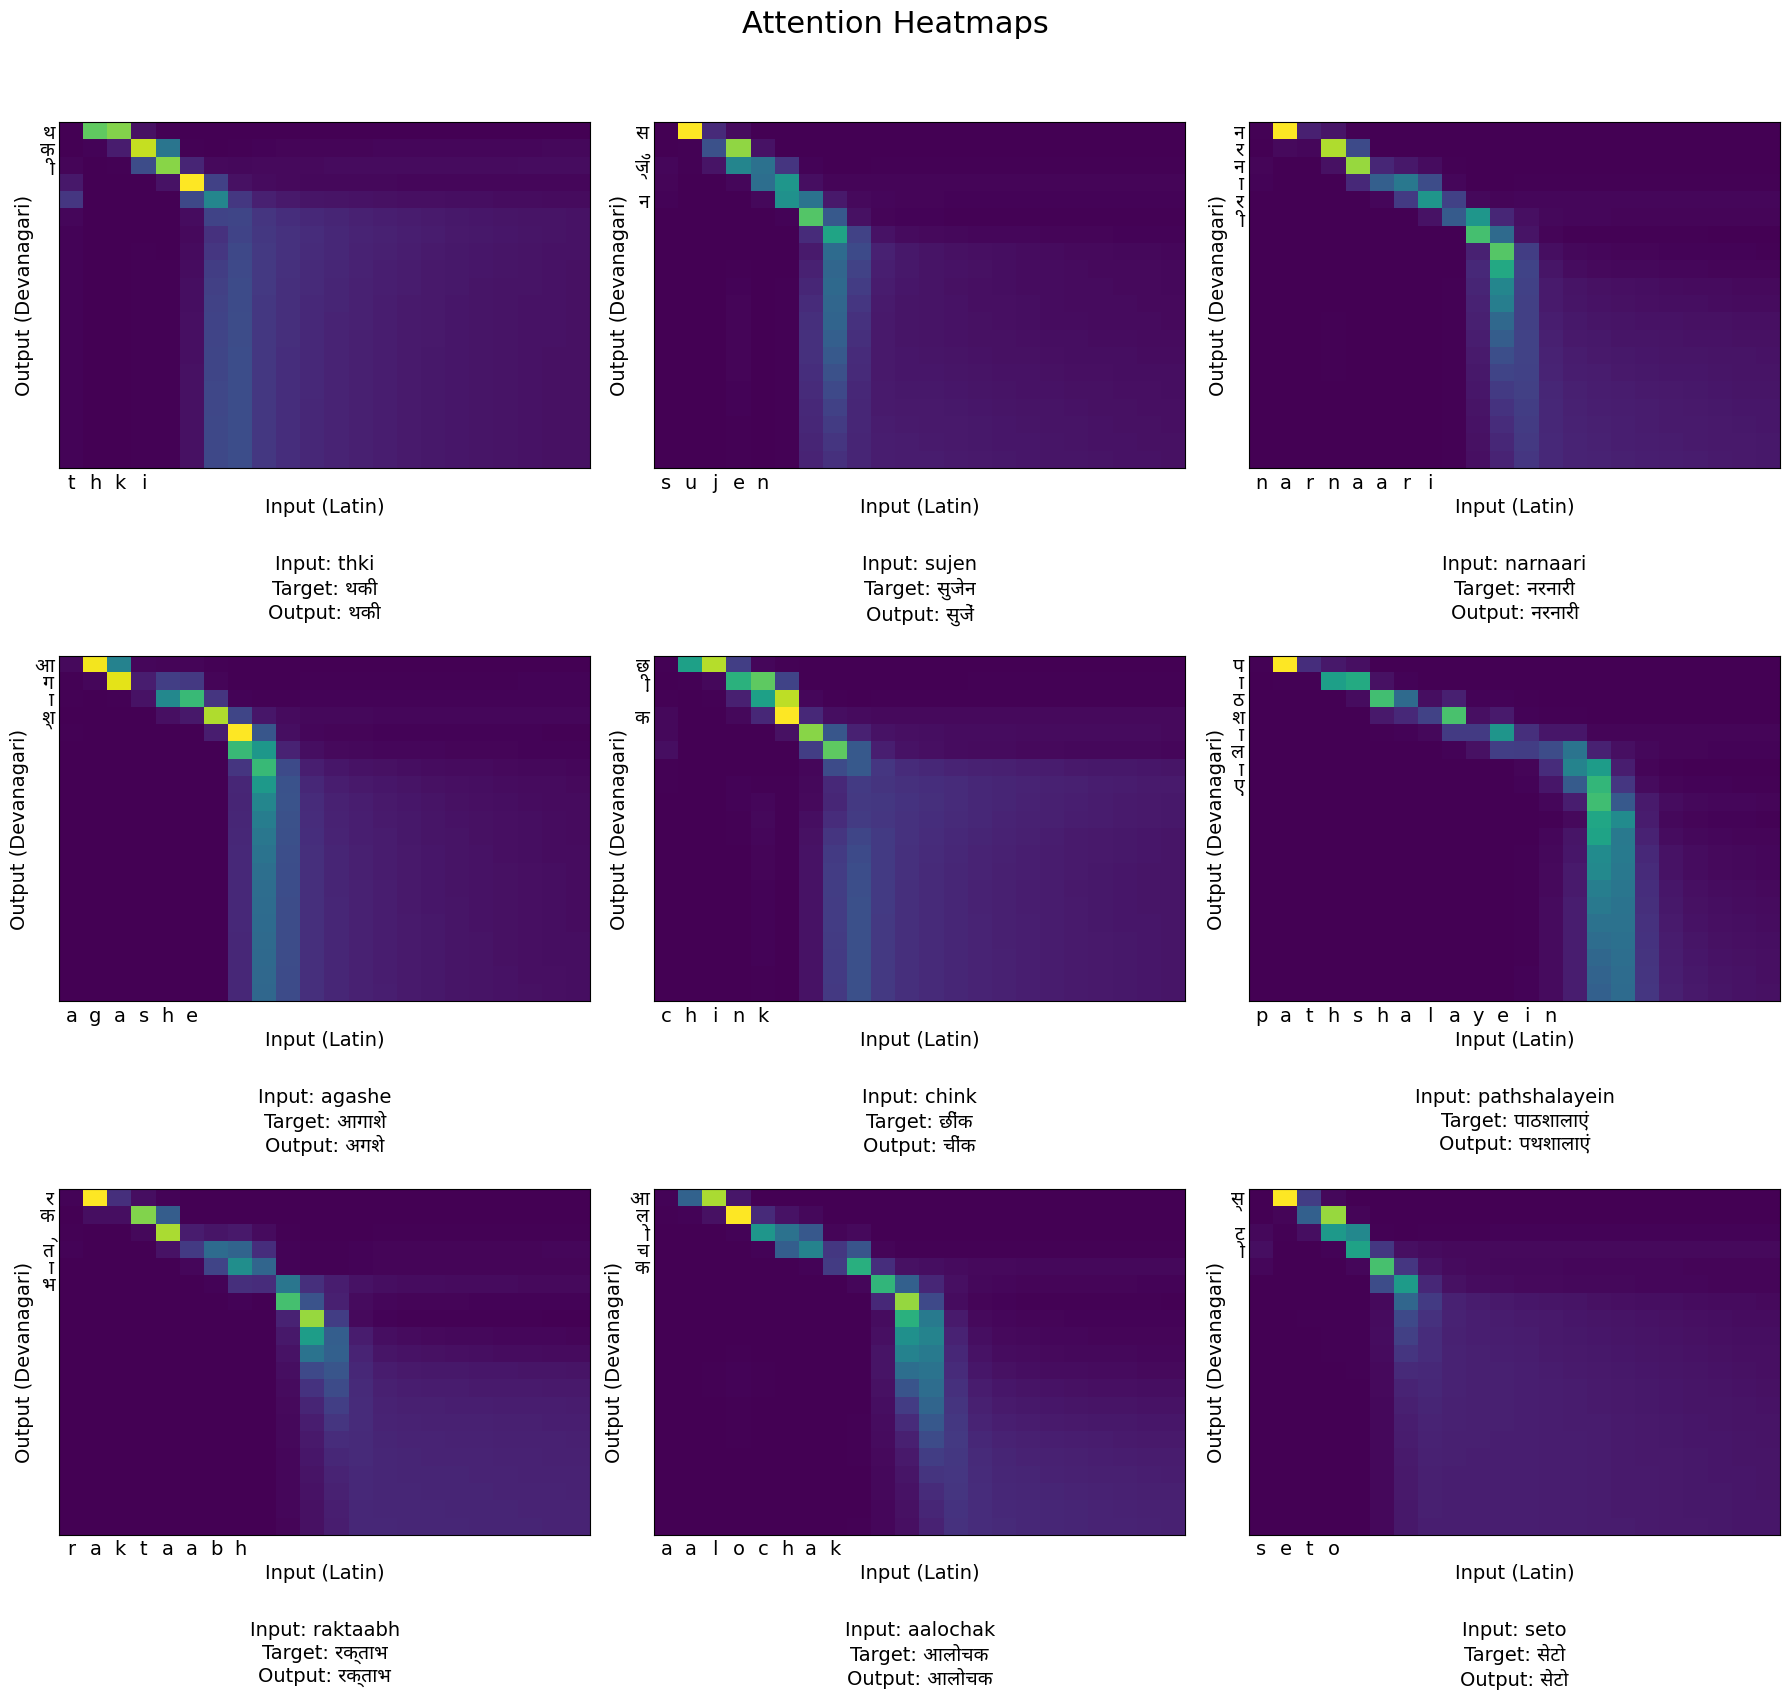

In [29]:
plot_attention_heatmaps_with_labels(best_model, data, num_samples=9)


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_lstm_activations(model, data, sample_idx=0, layer=0, max_units=50):
    """
    Plot the activations of LSTM hidden units for a specific input sequence.
    
    Args:
        model: Your seq2seq model
        data: Dictionary containing your data loaders and vocabularies
        sample_idx: Index of the sample in the test set to visualize
        layer: Which encoder layer to visualize (0 for first layer)
        max_units: Maximum number of hidden units to display (for readability)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get a sample from the test set
    batch = next(iter(data['test_loader']))
    src = batch['source'][sample_idx:sample_idx+1].to(device)  # Get just one sample
    
    # Record the input text for reference
    src_text = ''.join([data['src_idx2char'][idx.item()] for idx in src[0] 
               if idx.item() not in [data['src_vocab']['<start>'], 
                                    data['src_vocab']['<end>'], 
                                    data['src_vocab']['<pad>']]])
    
    with torch.no_grad():
        # Get embeddings and encoder outputs
        src_embedded = model.src_embed(src)
        encoder_outputs, _ = model._run_encoder(src_embedded)
        # encoder_outputs shape: [batch_size, seq_len, hidden_size]
        
        # Extract activations (remove batch dimension since batch=1)
        activations = encoder_outputs[0].cpu().numpy()  # [seq_len, hidden_size]
        
        # Only keep non-padding tokens
        pad_idx = data['src_vocab']['<pad>']
        seq_length = 0
        for i, token_id in enumerate(src[0].cpu().numpy()):
            if token_id == pad_idx:
                break
            seq_length += 1
        
        activations = activations[:seq_length]
        
        # Create label list for x-axis ticks (characters)
        char_labels = [data['src_idx2char'][idx.item()] for idx in src[0][:seq_length]]
        
    # Limit number of units to display
    if activations.shape[1] > max_units:
        activations = activations[:, :max_units]
    
    # Plot the activations
    plt.figure(figsize=(14, 8))
    plt.imshow(activations.T, aspect='auto', cmap='coolwarm')
    plt.colorbar(label='Activation Value')
    plt.xlabel('Input Character Position')
    plt.ylabel('LSTM Hidden Unit')
    plt.title(f'LSTM Encoder Activations for Input: "{src_text}"')
    
    # Set x ticks to show characters
    plt.xticks(range(len(char_labels)), char_labels, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('lstm_activations.png')
    plt.show()
    
    return activations


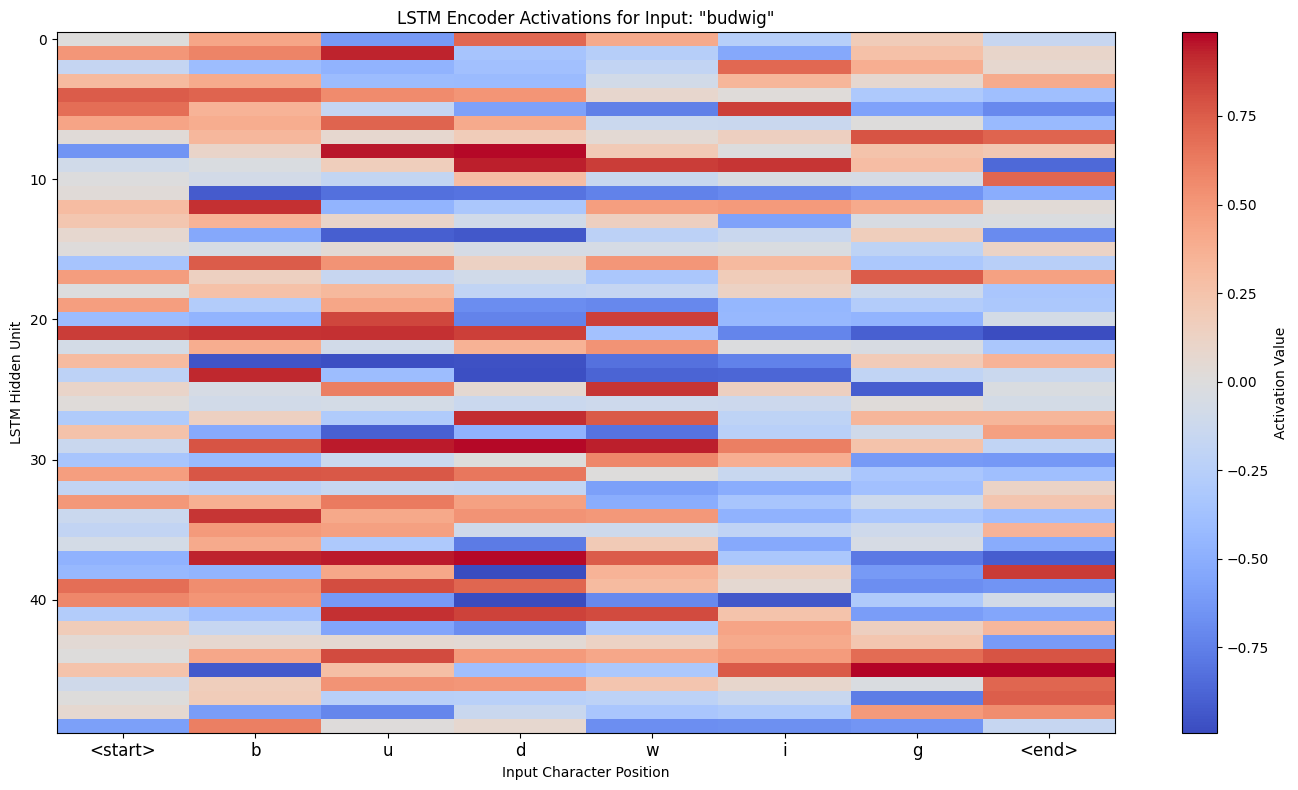

In [41]:
activations = plot_lstm_activations(best_model, data, sample_idx=0)


In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dl3wandb")


In [21]:
def train(config=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with wandb.init(config=config):
        config = wandb.config
        pad_idx = data['trg_vocab']['<pad>']
        
        # Model initialization
        model = Seq2Seq(
            src_vocab_size=len(data['src_vocab']),
            trg_vocab_size=len(data['trg_vocab']),
            embed_dim=config.embed_dim,
            hidden_size=config.hidden_size,
            enc_layers=config.enc_layers,
            dec_layers=config.dec_layers,
            cell_type=config.cell_type,
            dropout=config.dropout,
            attention=config.attention
        ).to(device)
        
        # Training setup
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
        best_val_loss = float('inf')
        
        for epoch in range(config.epochs):
            # Training
            model.train()
            train_loss = 0
            for batch in tqdm(data['train_loader'], desc=f"Epoch {epoch+1}"):
                src = batch['source'].to(device)
                trg = batch['target'].to(device)
                
                optimizer.zero_grad()
                output = model(src, trg, teacher_forcing_ratio=config.teacher_forcing)
                
                # Reshape for loss calculation
                output = output[:, 1:].reshape(-1, output.size(-1))
                targets = batch['target_output'].to(device).reshape(-1)
                
                loss = criterion(output, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for batch in data['dev_loader']:
                    src = batch['source'].to(device)
                    trg = batch['target'].to(device)
                    
                    output = model(src, trg, teacher_forcing_ratio=0)
                    output = output[:, 1:].reshape(-1, output.size(-1))
                    targets = batch['target_output'].to(device).reshape(-1)
                    
                    loss = criterion(output, targets)
                    val_loss += loss.item()
                    
                    # Calculate accuracy
                    _, predicted = torch.max(output, 1)
                    mask = targets != pad_idx
                    correct += ((predicted == targets) * mask).sum().item()
                    total += mask.sum().item()
            
            avg_train_loss = train_loss / len(data['train_loader'])
            avg_val_loss = val_loss / len(data['dev_loader'])
            val_acc = correct / total
            
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "val_acc": val_acc
            })
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "best_model.pth")


In [22]:



# Sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'embed_dim': {'values': [64, 128, 256]},
        'hidden_size': {'values': [128, 256, 512]},
        'enc_layers': {'values': [1, 2]},
        'dec_layers': {'values': [1, 2]},
        'cell_type': {'values': ['lstm', 'gru', 'rnn']},
        'dropout': {'values': [0.0, 0.2, 0.3]},
        'learning_rate': {'values': [0.001, 0.0005]},
        'teacher_forcing': {'values': [0.5, 0.7]},
        'epochs': {'value': 10},
        'attention' : {'value':True}
    }
}

# Initialize wandb and run sweep
wandb.login(key =secret_value_0 )
sweep_id = wandb.sweep(sweep_config, project="DA6401_assignment3")
wandb.agent(sweep_id, train)

# Test function (to run after training)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s021 (da24s021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: c4wteegb
Sweep URL: https://wandb.ai/da24s021-indian-institute-of-technology-madras/DA6401_assignment3/sweeps/c4wteegb


wandb: Agent Starting Run: gbul4ecf with config:
wandb: 	attention: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	teacher_forcing: 0.5


Epoch 10: 100%|██████████| 691/691 [00:32<00:00, 21.40it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▆▇▇██▇█
val_loss,█▄▂▂▁▁▁▁▂▂
epoch,9
train_loss,0.47303
val_acc,0.7281
val_loss,1.03389


wandb: Agent Starting Run: bbkcuvc3 with config:
wandb: 	attention: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 2
wandb: 	dropout: 0
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	teacher_forcing: 0.7


Epoch 10: 100%|██████████| 691/691 [00:37<00:00, 18.19it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▆▇█▇▇██
val_loss,█▄▂▂▁▁▁▂▂▂
epoch,9
train_loss,0.26536
val_acc,0.74327
val_loss,1.13481


wandb: Agent Starting Run: 0614hk02 with config:
wandb: 	attention: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	teacher_forcing: 0.5


Epoch 10: 100%|██████████| 691/691 [00:35<00:00, 19.42it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▆▇█▇██▇
val_loss,█▅▃▃▃▁▃▂▃▃
epoch,9
train_loss,0.42097
val_acc,0.73601
val_loss,0.98869


wandb: Agent Starting Run: p1mwtvpc with config:
wandb: 	attention: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	teacher_forcing: 0.5


Epoch 10: 100%|██████████| 691/691 [00:34<00:00, 19.92it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▃▅▆█▇▇▇█▇
val_loss,█▆▃▃▁▂▃▂▂▂
epoch,9
train_loss,0.51858
val_acc,0.71457
val_loss,1.02315


wandb: Agent Starting Run: uolbaj0z with config:
wandb: 	attention: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	teacher_forcing: 0.5


Epoch 10: 100%|██████████| 691/691 [00:35<00:00, 19.35it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▄▃▂▁▁▁▁▂▂
epoch,9
train_loss,0.4238
val_acc,0.74311
val_loss,0.98908


wandb: Agent Starting Run: pan9gsrj with config:
wandb: 	attention: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	teacher_forcing: 0.5
wandb: Ctrl + C detected. Stopping sweep.
